# Bayesian Regression Using NumPyro

In this tutorial, we will explore how to do bayesian regression in NumPyro. In particular, we would like to understand the following:

 - Write a hierarchical parameteric model using NumPyro.
 - Run inference using MCMC in NumPyro, in particular, using the No U-Turn Sampler (NUTS) to get a posterior distribution over our regression parameters of interest.
 - Estimate the inference validity.
 - Demonstrate how to perform model comparison based on prior or posterior predictive model evidence.

## Tutorial Outline:

1. [Dataset](#Dataset)
2. [Regression Model](#Regression-Model)
3. [Inference](#Inference)
    - [Posterior distribution over regression parameters](#Posterior-distribution-over-regression-parameters)
    - [Model validation](#Model-validation)
4. [Model comparison](#Model-comparison)
    - [Posterior predictive log-likelihood](#Posterior-predictive-log-likelihood)
    - [Prior predictive log-likelihood](#Prior-predictive-log-likelihood)
5. [References](#References)

In [1]:
import jax.numpy as np
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import seaborn as sns

import numpyro as npyro
npyro.enable_validation()
npyro.set_platform(platform='cpu')

from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('seaborn-notebook')

# Dataset

For this example, we will use a generated data set, where predictor variables are sampled from a Student-t distribution with large variance. In principle, changing the predictor variables should not influence the quality of inference. Nevertheless, we can perform the model valiadtion also using the predictors from the availible data sets.

Note the following:

 - JAX uses functional PRNGs. Unlike other languages / frameworks which maintain a global random state, in JAX, every call to a sampler requires an [explicit PRNGKey](https://github.com/google/jax#random-numbers-are-different). We will split our initial random seed for subsequent operations, so that we do not accidentally reuse the same seed.

In [5]:
vqr = vmap(np.linalg.qr)
vdot = vmap(np.dot)
vinv = vmap(np.linalg.inv)

T = 100
nf = 6
ns = 10

X = np.broadcast_to(np.log(np.arange(1, T + 1)), (ns, T))

phases = np.broadcast_to(np.expand_dims(np.arange(4), -1), (4, 25)).reshape(-1)
M = np.broadcast_to(np.eye(4)[phases], (ns, T, 4))

rng_key = random.PRNGKey(0)
X = np.concatenate([np.expand_dims(X, -1), M], -1)
X = np.concatenate([X, random.normal(rng_key, shape=(ns, T, 1))], -1)

# center non-constant factors
X -= np.expand_dims(X.mean(-2) * np.array([1., 0, 0, 0, 0, 1.]), -2)

# Do Q-R decomposition to decorelate predictors and consequently the posterior distribution, see 
# https://mc-stan.org/users/documentation/case-studies/qr_regression.html for more details
# This step is important for predictors of response times.
Q, R = vqr(X)
Q = Q * T
R = R / T
R_inv = vinv(R)

print(Q.shape, X.shape, R.shape)
np.all(np.isclose(X, vdot(Q, R), atol=1e-4))

(10, 100, 6) (10, 100, 6) (10, 6, 6)


DeviceArray(True, dtype=bool)

# Regression Model

Let us now write a regressionn model in *NumPyro* as a linear function. 

We write the hierarchical paramteric model in the NumPyro model as follows. While the code should largely be self-explanatory, take note of the following:

 - In NumPyro, *model* code is any Python callable which can optionally accept additional arguments and keywords. In our case, these arguments and keywords remain static during inference, but we can reuse the same model to generate [predictions](#Posterior-Predictive-Distribution) for a posterior predictive check.
 
 - In addition to regular Python statements, the model code also contains primitives like `sample`. These primitives can be interpreted with various side-effects using effect handlers. For more on effect handlers, refer to [[3](#References)], [[4](#References)]. For now, just remember that a `sample` statement makes this a stochastic function that samples some latent parameters from a *prior distribution*. Our goal is to infer the *posterior distribution* of these parameters conditioned on observed data.
 
 - The reason why the response variable is optional is that we would like to reuse this model to sample from the posterior predictive distribution. See the [section](#Posterior-Predictive-Distribution) on plotting the posterior predictive distribution, as an example.
 
 - We will use global-local shrinkage priors over regression coefficient. This was shown to be the best way for automatic identification of relevant non-zero regression coefficients, see [[9, 10](#References)]. 

(10, 100) (10, 6) (10,)


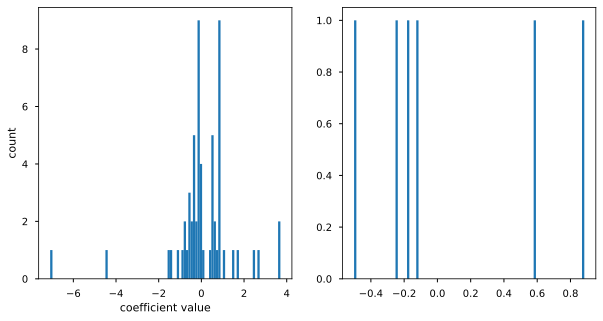

In [16]:
# bellow nf denotes numbre of factors and T number of observations per subject ns.
def model(Q, R_inv, ns, nf, y=None):
    
    s = npyro.sample('s', dist.Exponential(1. * np.ones(nf)))
    m = npyro.sample('m', dist.Normal(np.zeros(nf), 1.))

    sigma = npyro.sample('sigma', dist.InverseGamma(2.*np.ones((ns,)), 1.))
    tau = npyro.sample('tau', dist.Exponential(100. * np.ones(ns)))
    
    with npyro.plate('facts', nf):
        with npyro.plate('subs', ns):
            lam = npyro.sample('lam', dist.HalfCauchy(1.))
            var_theta = npyro.sample('var_theta', dist.Normal(0., 1.))
    
    gb = npyro.deterministic('group_beta', m * s)
    theta = npyro.deterministic('theta', vinv(R_inv).dot(gb) + np.expand_dims(tau, -1) * lam * var_theta)
    
    beta = npyro.deterministic('beta', vdot(R_inv, theta))
    mu = vdot(Q, theta) 
    
    obs = npyro.sample('obs', dist.Normal(mu, np.expand_dims(sigma, -1)), obs=y)
    
    return obs, beta, sigma, gb

with handlers.seed(rng_seed=12345):
    y, betas, sigmas, group_beta = model(Q, R_inv, ns, nf)
    
print(y.shape, betas.shape, sigmas.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(betas.flatten(), bins=100);
axes[0].set_xlabel('coefficient value');
axes[0].set_ylabel('count');

axes[1].hist(group_beta.flatten(), bins=100);

# Inference

We will use the No U-Turn Sampler (see [[5](#References)] for more details on the NUTS algorithm) to run inference on this simple model.

The Hamiltonian Monte Carlo (or, the NUTS) implementation in NumPyro takes in a potential energy function. This is the negative log joint density for the model. Therefore, for our model description above, we need to construct a function which given the parameter values returns the potential energy (or negative log joint density). Additionally, the verlet integrator in HMC (or, NUTS) returns sample values simulated using Hamiltonian dynamics in the unconstrained space. As such, continuous variables with bounded support need to be transformed into unconstrained space using bijective transforms. We also need to transform these samples back to their constrained support before returning these values to the user. Thankfully, this is handled on the backend for us, within a convenience class for doing [MCMC inference](https://numpyro.readthedocs.io/en/latest/mcmc.html#numpyro.mcmc.MCMC) that has the following methods:

   - `run(...)`: runs warmup, adapts steps size and mass matrix, and does sampling using the sample from the warmup phase.
   - `print_summary()`: print diagnostic information like quantiles, effective sample size, and the Gelman-Rubin diagnostic.
   - `get_samples()`: gets samples from the posterior distribution.

Note the following:
 
 - We run inference with the `NUTS` sampler. To run vanilla HMC, we can instead use the [HMC](https://numpyro.readthedocs.io/en/latest/mcmc.html#numpyro.mcmc.HMC) class.

In [17]:
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 2000, 1000

# Run NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, Q, R_inv, ns, nf, y=y)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [01:22<00:00, 36.18it/s, 511 steps of size 1.33e-02. acc. prob=0.85]  



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      lam[0,0]      1.59      3.95      0.73      0.00      2.95    470.04      1.00
      lam[0,1]      1.34      2.46      0.71      0.00      2.80    525.02      1.00
      lam[0,2]      1.22      2.15      0.67      0.00      2.56    595.90      1.00
      lam[0,3]     17.59     27.24      8.92      1.33     38.29    406.35      1.00
      lam[0,4]      1.68      2.66      0.85      0.00      3.60    621.60      1.00
      lam[0,5]      3.56      5.74      1.84      0.02      7.65    510.86      1.00
      lam[1,0]      1.59      3.17      0.78      0.00      3.22    782.00      1.00
      lam[1,1]      2.18     10.44      0.88      0.01      4.35    862.23      1.00
      lam[1,2]      1.66      4.36      0.76      0.00      3.50    888.95      1.00
      lam[1,3]      2.79     11.11      1.03      0.00      5.14    851.28      1.00
      lam[1,4]      1.77      3.87      0.71      0.00      3.64

## Posterior distribution over regression parameters

We notice that the progress bar gives us online statistics on the acceptance probability, step size and number of steps taken per sample while running NUTS. In particular, during warmup, we adapt the step size and mass matrix to achieve a certain target acceptance probability which is 0.8, by default. We were able to successfully adapt our step size to achieve this target in the warmup phase.

During warmup, the aim is to adapt hyper-parameters such as step size and mass matrix (the HMC algorithm is very sensitive to these hyper-parameters), and to reach the typical set (see [[6](#References)] for more details). If there are any issues in the model specification, the first signal to notice would be low acceptance probabilities or very high number of steps. We use the sample from the end of the warmup phase to seed the MCMC chain (denoted by the second `sample` progress bar) from which we generate the desired number of samples from our target distribution.

At the end of inference, NumPyro prints the mean, std and 90% CI values for each of the latent parameters. It also prints other convergence diagnostics on the latent parameters in the model, including [effective sample size](https://numpyro.readthedocs.io/en/latest/diagnostics.html#numpyro.diagnostics.effective_sample_size) and the [gelman rubin diagnostic](https://numpyro.readthedocs.io/en/latest/diagnostics.html#numpyro.diagnostics.gelman_rubin) ($\hat{R}$). The value for these diagnostics indicates that the chain has converged to the target distribution. In our case, the "target distribution" is the posterior distribution over the latent parameters that we are interested in. Note that this is often worth verifying with multiple chains for more complicated models. In the end, `samples_1` is a collection (in our case, a `dict` since `init_samples` was a `dict`) containing samples from the posterior distribution for each of the latent parameters in the model.

To understand the validity of posterior estimates over regression coefficients let us plot first the true parameter values against the posterior distribution of estimated parameter values.

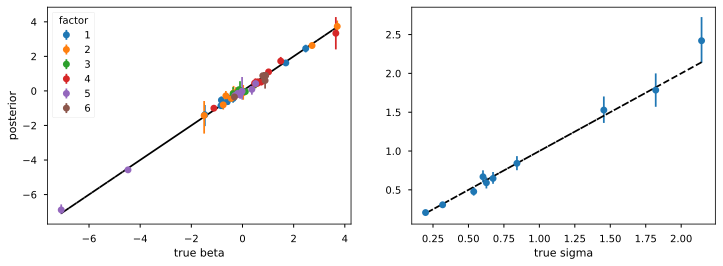

In [18]:
post_betas = samples_1['beta']
post_sigma = samples_1['sigma']

hpdi_b = hpdi(post_betas, 0.9)
hpdi_s = hpdi(post_sigma, 0.9)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

med_b = np.median(post_betas, 0)
yerr = np.vstack([med_b - hpdi_b[0], hpdi_b[1] - med_b])

for f in range(nf):
    axes[0].errorbar(betas[..., f], 
                     med_b[..., f], 
                     yerr=yerr[..., f].reshape(2, -1), 
                     marker='o', 
                     linestyle='', 
                     label=f+1)

axes[0].legend(title='factor')

axes[0].plot(betas.reshape(-1), betas.reshape(-1), 'k--')
axes[0].set_xlabel('true beta')
axes[0].set_ylabel('posterior')

med_s = np.median(post_sigma, 0)
yerr = np.vstack([med_s - hpdi_s[0], hpdi_s[1] - med_s]);
axes[1].errorbar(sigmas.reshape(-1), med_s.reshape(-1), yerr=yerr.reshape(2, -1), marker='o', linestyle='');
axes[1].plot(sigmas.reshape(-1), sigmas.reshape(-1), 'k--');
axes[1].set_xlabel('true sigma');


We have good parameter recovery as the estimated values are well correlated with the true values. Still, this tell us little about how well we are predicting the responses.

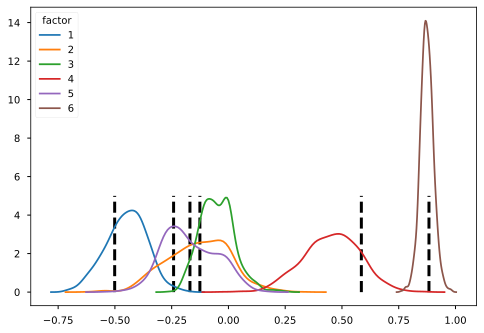

In [33]:
for f in range(nf):
    sns.kdeplot(onp.array(samples_1['group_beta'][:, f]).astype(onp.double), label=f+1)
    plt.vlines(group_beta[f], 0, 5, lw=3, linestyle='--' )
plt.legend(title='factor');

## Model validation

To look at our regression fit, let us plot the regression line using our posterior estimates for the regression parameters, along with the 90% Credibility Interval (CI). Note that the [hpdi](https://numpyro.readthedocs.io/en/latest/diagnostics.html#numpyro.diagnostics.hpdi) function in NumPyro's diagnostics module can be used to compute CI.

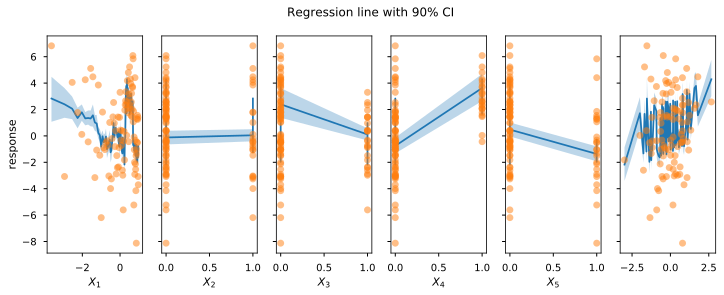

In [34]:
def plot_regression(x, y_mean, y_hpdi, s=0):
    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=nf, figsize=(12, 4), sharey=True)
    for f in range(nf):
        idx = np.argsort(x[s, :, f])
        sx = x[s, idx, f]
        mean = y_mean[s, idx]
        hpdi = y_hpdi[:, s, idx]
        sy = y[s, idx]
        axes[f].plot(sx, mean)
        axes[f].plot(sx, sy, 'o', alpha=.5)
        axes[f].fill_between(sx, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    
    return fig, axes

# Compute empirical posterior distribution over predictions
posterior_pred = (np.expand_dims(post_betas, -2) * X).sum(-1)

mean_pred = posterior_pred.mean(0)
hpdi_pred = hpdi(posterior_pred, 0.9)
fig, axes = plot_regression(X, mean_pred, hpdi_pred, s=0)
fig.suptitle('Regression line with 90% CI')
axes[0].set(xlabel=r'$X_1$', ylabel='response');
for i in range(4):
    axes[i+1].set_xlabel(r'$X_{}$'.format(i+2))

We can see from the plot, that the CI broadens towards the tails where the data is relatively sparse, as can be expected. Still, some responses appear to deviated significantly from the regression line.

Let us now look at the posterior predictive distribution to see how our predictive distribution looks with respect to the observed responses (simulated log response times). To get samples from the posterior predictive distribution, we need to run the model by substituting the latent parameters with samples from the posterior. NumPyro provides a handy [Predictive](http://num.pyro.ai/en/latest/utilities.html#numpyro.infer.util.Predictive) utility for this purpose. Note that by default we generate a single prediction for each sample from the joint posterior distribution, but this can be controlled using the `num_samples` argument.

In [35]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
post_responses = predictive.get_samples(rng_key_, Q, R_inv, ns, nf)['obs']

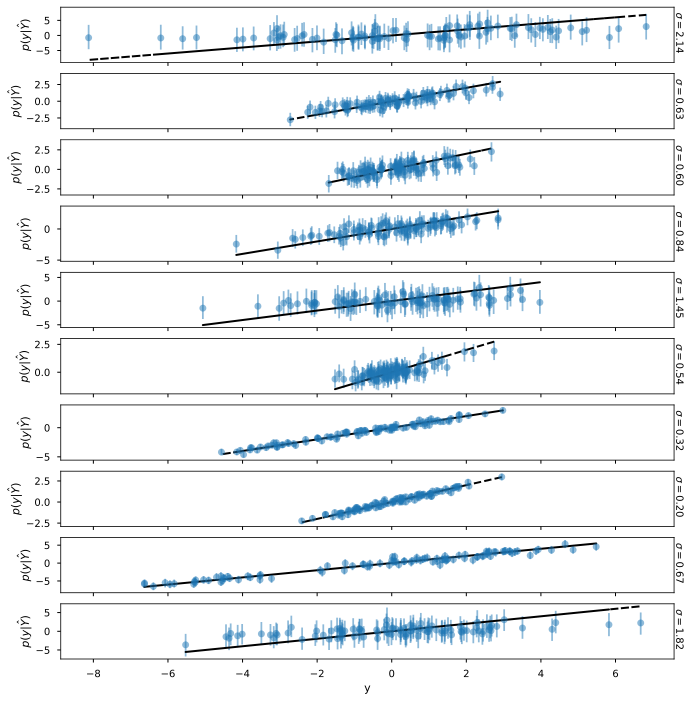

In [36]:
mu_resp = np.mean(post_responses, 0)
hpdi_resp = hpdi(post_responses, 0.9)

fig, axes = plt.subplots(ns, 1, figsize=(11, 12), sharex=True)
for s in range(ns):
    yerr = [mu_resp[s] - hpdi_resp[0, s], hpdi_resp[1, s] - mu_resp[s]]
    axes[s].errorbar(y[s], mu_resp[s], yerr=yerr, linestyle='', marker='o', alpha=.5)
    axes[s].plot(y[s], y[s], 'k--', lw=2)
    axes[s].annotate(r'$\sigma={0:.2f}$'.format(sigmas[s]), xy=(1., 0.2), xycoords="axes fraction", rotation=-90)
    axes[s].set_ylabel(r'$p(y|\hat{Y})$')
    
axes[-1].set_xlabel(r'y');

# Model comparison

When we have large enough data set it is straightforward to determine a subset of releveant predictors using the hierrachical model described above. However, in practice we are confronted also with a problem of determinig whether a certain feature should be consider as a predictor for the linear regression model. A set of relevant predictors can be determined using Bayesian model comparison. Here we will consider the following model variants

- model with additional constant factor
- models in which one feature was removed

We will use the data from the full model to perform model comparison with these alternative models. The expected result is that the true model should have the highest posterior predictive log-likelihood, as this was the model we actually used to generate the data.

## Posterior predictive log-likelihood

We can also compute the log likelihood for this model given the dataset, and the posterior predictive log-likelihood [[6](#References)] which is given by 
$$ \ln \prod_{i=1}^{N} \int p(y_i | \theta) p_{post}(\theta) d\theta 
\approx \sum_{i=1}^N \ln \frac{\sum_s p(y^i|\theta^{s})}{S} \\
= \sum_{i=1}^N \ln \left[ \sum_s p(y^i|\theta^{s}) \right] - N\cdot \ln(S)
$$

Here, $i$ indexes the observed data points $y$ and $s$ indexes the posterior samples over the latent parameters $\theta$. If the posterior predictive density for a model has a comparatively high value, it indicates that the observed data-points have higher probability under the given model. Note that NumPyro provides the [log_likelihood](http://num.pyro.ai/en/latest/utilities.html#log-likelihood) utility function that can be used directly for computing `log likelihood` for any general model. We will use this to compute the posterior predictive log-likelihood. The prior predicive log likelihood is obtained the same way by replacing sample from the posterior with the sample from prior distribution.

In [37]:
from numpyro.infer import log_likelihood


def log_pred_density(model, samples, *args, **kwargs):
    log_lk = log_likelihood(model, samples, *args, **kwargs)['obs']
    n = log_lk.shape[0]
    print(log_lk.shape)
    return (logsumexp(log_lk, 0) - np.log(n)).sum()

print('posterior predictive log-likelihood: {}'.format(log_pred_density(model,
                                                                     samples_1, 
                                                                     Q,
                                                                     R_inv,
                                                                     ns, 
                                                                     nf, 
                                                                     y=y)))

(1000, 10, 100)
posterior predictive log-likelihood: -1085.664794921875


We can define Q, R matrices for reduced X, in which one of the features is removed. This corresponds to the model in which the corresponding coefficients for that feature are set to zero.

In [38]:
x_set = [X[..., 1:], X[..., :-1]]
q_set = []
r_set = []
samples_2 = []
for x in x_set:
    q, r = vqr(x)
    q = q * T
    r = r / T
    q_set.append(q)
    r_inv = vinv(r)
    r_set.append(r_inv)
   
    rng_key, rng_key_ = random.split(rng_key)
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup, num_samples)
    mcmc.run(rng_key_, q, r_inv, ns, nf-1, y=y)
    samples_2.append(mcmc.get_samples())

sample: 100%|██████████| 3000/3000 [00:51<00:00, 58.03it/s, 127 steps of size 2.93e-02. acc. prob=0.88]  


In [40]:
for samples, q, r_inv in zip(samples_2, q_set, r_set):
    print('posterior predictive log-likelihood: {}'.format(log_pred_density(model,
                                                                     samples, 
                                                                     q,
                                                                     r_inv,
                                                                     ns, 
                                                                     nf-1,
                                                                     y=y)))

(1000, 10, 100)
posterior predictive log-likelihood: -1333.45703125
(1000, 10, 100)
posterior predictive log-likelihood: -1574.106689453125


## Prior predictive log-likelihood

Comparable to the posterior predictive log-likelihood, the prior predictive log likelihood (or just marginal likelihood) is defined as  
$$ \ln \prod_{i=1}^{n} \int p(y_i | \theta) p_{prior}(\theta) d\theta 
\approx \sum_{i=1}^n \ln \frac{\sum_s p(y^i|\theta^{s})}{S} \\
= \sum_{i=1}^n \ln \left[ \sum_s p(y^i|\theta^{s}) \right] - n\cdot \ln(S)
$$.

Here, $s$ indexes the prior samples over the latent parameters $\theta$. If the prior predictive density for a model has a comparatively high value, it indicates that the observed data-points have higher probability under the given model. We can obtain this values by generating samples from the prior instead of prosterior distribution. Note that as we are using a rather flat prior (weakly informative prior) we need substantially larger number of samples to obtain an accurate estimate of the log model evidence. 

In [43]:
num_samples = 10000

x_set = [X, X[..., 1:], X[..., :-1]]
q_set = []
r_set = []
samples_3 = []
for i, x in enumerate(x_set):
    if i == 0:
        n = nf
    else:
        n = nf - 1
    
    q, r = vqr(x)
    q = q * T
    r = r / T
    r_inv = vinv(r)
    q_set.append(q)
    r_set.append(r_inv)

    rng_key, rng_key_ = random.split(rng_key)
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup, num_samples)
    mcmc.run(rng_key_, q, r_inv, ns, n)
    samples_3.append(mcmc.get_samples())
    samples_3[-1].pop('obs')

sample: 100%|██████████| 12000/12000 [20:18<00:00,  9.85it/s, 1023 steps of size 5.01e-03. acc. prob=0.74]


Now we can compute log marginal likelihood under prior samples

In [44]:
for smpl, q, r_inv, n in zip(samples_3, q_set, r_set, [nf, nf-1, nf-1]):
    print('prior predictive log-likelihood: {}'.format(log_pred_density(model,
                                                                        smpl, 
                                                                        q,
                                                                        r_inv,
                                                                        ns, 
                                                                        n, 
                                                                        y=y)))

(10000, 10, 100)
prior predictive log-likelihood: -2061.1787109375
(10000, 10, 100)
prior predictive log-likelihood: -2135.3544921875
(10000, 10, 100)
prior predictive log-likelihood: -2106.537109375


Here we also obtain the larges model evidence for the true model, which is equivalent to the posterior predictive log-likelihood, where the model with the highest likelihood was the model with a constant. However, a difficulty with using prior predictive log-likelihood is large variability of samples in the presence of uninformative priors with fat tails. Hence, the results can vary substantially from one run to the next and require much larger number of samples for the estimate to converge to irrelevant decimal points.  

## References

1. McElreath, R. (2016). Statistical Rethinking: A Bayesian Course with Examples in R and Stan CRC Press.
2. Stan Development Team. [Stan User's Guide](https://mc-stan.org/docs/2_19/stan-users-guide/index.html)
3. Goodman, N.D., and StuhlMueller, A. (2014). [The Design and Implementation of Probabilistic Programming Languages](http://dippl.org/)
4. Pyro Development Team. [Poutine: A Guide to Programming with Effect Handlers in Pyro](http://pyro.ai/examples/effect_handlers.html)
5. Hoffman, M.D., Gelman, A. (2011). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo.
6. Betancourt, M. (2017). A Conceptual Introduction to Hamiltonian Monte Carlo.
7. JAX Development Team (2018). [Composable transformations of Python+NumPy programs: differentiate, vectorize, JIT to GPU/TPU, and more](https://github.com/google/jax)
8. Gelman, A., Hwang, J., and Vehtari A. [Understanding predictive information criteria for Bayesian models](https://arxiv.org/pdf/1307.5928.pdf)
9. Anindya Bhadra, Jyotishka Datta, Nicholas G. Polson, Brandon Willard, [Default Bayesian analysis with global-local shrinkage priors](https://academic.oup.com/biomet/article/103/4/955/2659031)

10. Piironen, Juho, and Aki Vehtari. [Sparsity information and regularization in the horseshoe and other shrinkage priors.](https://projecteuclid.org/euclid.ejs/1513306866)
